In [0]:
from keras.layers import Input, Conv2D, Lambda, Subtract, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
from sklearn.model_selection import train_test_split
from google.colab import drive
from tqdm import tqdm
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping

In [46]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!cd .

In [0]:
path = 'gdrive/My Drive/Omniglot Dataset/images_background'

In [0]:
def load_data():
    
    lang_folders = os.listdir(path)
    
    all_chars = []    
    
    lim = 0
    
    for i in tqdm(lang_folders):  
      
        if (lim >= 5):
          break
        
        chars =os.listdir(path + '/' + i)
        
        for char in chars:
            
            all_images = os.listdir(path + '/' + i + '/' + char)
            
            characters = []
            
            for img in all_images:
                
                curr_image = cv2.imread(path + '/' + i + '/' + char+ '/' + img)                    
                
                characters.append(curr_image)                                                                            
                
            characters = np.array(characters)
                               
            all_chars.append(characters)
            
        lim = lim + 1
            
    return np.array(all_chars)
    
    

In [50]:
all_images= load_data()




  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]

  7%|▋         | 2/30 [00:03<00:38,  1.38s/it]

 10%|█         | 3/30 [00:04<00:39,  1.44s/it]

 13%|█▎        | 4/30 [00:07<00:45,  1.77s/it]

 17%|█▋        | 5/30 [00:09<00:49,  1.97s/it]

In [0]:
def make_pairs(all_images):
    
    samples = all_images[:,0,:,:,:]
    
    X = []
    Y = []
    
    for i in range(all_images.shape[0]):
        
         for j in  range(all_images.shape[1]):
                
                X.append([all_images[i,0,:,:,:], all_images[i,j,:,:,:]])
                
                Y.append(1)
                
         
         for j in range(all_images.shape[0]):
                
                if i is j:
                    continue
                
                X.append([all_images[i,0,:,:,:], all_images[j,0,:,:,:]])
                
                Y.append(0)
                

    return np.array(X), np.array(Y)

In [52]:
all_images.shape

(156, 20, 105, 105, 3)

In [0]:
x,y = make_pairs(all_images)

In [55]:
x.shape

(27300, 2, 105, 105, 3)

In [0]:
X,Y = shuffle(x,y)

In [57]:
X.shape

(27300, 2, 105, 105, 3)

In [0]:
X_train, X_test, Y_train, Y_test = np.array(train_test_split(X,Y, test_size = 0.2))

In [0]:
X,Y,x,y = None,None,None,None

In [0]:
X_train1 = X_train[:,0,:,:,:]
X_train2 = X_train[:,1,:,:,:]
X_test1 = X_test[:,0,:,:,:]
X_test2 = X_test[:,1,:,:,:]

In [0]:
class Siamese_Model() : 
    
    def __init__(self, shape, name = None) : 
        
        self.input_shape =shape
        

        
    def getModel(self):
        
        W_init = RandomNormal(mean =0 , stddev = 1e-2, seed = None)
        b_init = RandomNormal(mean = 0.5, stddev = 1e-2, seed = None)
        
        left_input = Input(self.input_shape)
        right_input = Input(self.input_shape)

        convnet = Sequential()
        convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=self.input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
        convnet.add(Flatten())
        convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

        encoded_l = convnet(left_input)
        encoded_r = convnet(right_input)

        L1_distance = lambda x: K.abs(x[0]-x[1])
        both = Lambda(L1_distance)([encoded_l,encoded_r])
        prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
        self.siamese_net = Model(input=[left_input,right_input],output=prediction)
        
        return self.siamese_net
        

In [62]:
model = Siamese_Model((105,105,3)).getModel()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38960448    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]               
          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [0]:
es = EarlyStopping(monitor = 'val_acc', mode = 'max')
optimizer = Adam(0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics = ['accuracy'])

In [64]:
history = model.fit( [X_train1, X_train2] , Y_train, batch_size = 16, epochs = 15, validation_data = [[X_test1,X_test2], Y_test], callbacks = [es])

Train on 21840 samples, validate on 5460 samples
Epoch 1/15
21840/21840 [==============================] - 227s 10ms/step - loss: 1.2636 - acc: 0.9092 - val_loss: 0.4943 - val_acc: 0.9392
Epoch 2/15
21840/21840 [==============================] - 224s 10ms/step - loss: 0.3287 - acc: 0.9691 - val_loss: 0.2298 - val_acc: 0.9813
Epoch 3/15
21840/21840 [==============================] - 224s 10ms/step - loss: 0.1729 - acc: 0.9879 - val_loss: 0.1551 - val_acc: 0.9842
Epoch 4/15
21840/21840 [==============================] - 224s 10ms/step - loss: 0.1145 - acc: 0.9939 - val_loss: 0.1135 - val_acc: 0.9916
Epoch 5/15
21840/21840 [==============================] - 224s 10ms/step - loss: 0.0941 - acc: 0.9952 - val_loss: 0.1093 - val_acc: 0.9870


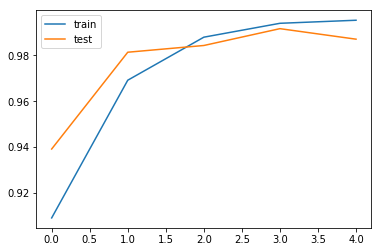

In [65]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
test_path1 = 'gdrive/My Drive/Omniglot Dataset/images_evaluation/Angelic/character02' 
test_path2 = 'gdrive/My Drive/Omniglot Dataset/images_evaluation/Atlantean/character02' 

In [0]:
tis1 = os.listdir(test_path1)
tis2 = os.listdir(test_path2)
img1 = cv2.imread(test_path1 + '/' + tis1[0])
img2 = cv2.imread(test_path2 +  '/' + tis2[1])

In [0]:
preds = model.predict([[img1],[img2]])

In [81]:
preds

array([[0.07336505]], dtype=float32)

In [0]:
model.save('Siamese_Network.h5')

In [71]:
from google.colab import files
files.download('Siamese_Network.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 35676, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil